In [1]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [2]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [3]:
N_YEARS = 25
N_CUTS = 10
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('1997-03-07', datetime.date(2022, 3, 7))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


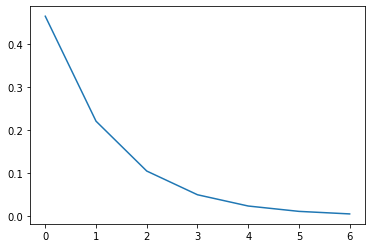

In [4]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [5]:
SD = SDS[TODAY.weekday()]
SD

0.46566128730773904

In [6]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA',  # NY Stock Exchange (total)
           '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [7]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [8]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download()

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000


In [9]:
data['Date'].tail()

6286   2022-02-28
6287   2022-03-01
6288   2022-03-02
6289   2022-03-03
6290   2022-03-04
Name: Date, dtype: datetime64[ns]

In [10]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [11]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [12]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(f'Unexpected error getting {stock} data. '
              'Initialized as None.')

In [13]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [14]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best.json', 'w') as f:
        json.dump(best_param_set, f)




----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.7053995523273566
Refitting current best...
Current best ma returns: 3.972572048818941
Fraction Invested: 0.9607454308175882
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 100


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.7053995523273566
Refitting current best...
Current best ew_ma returns: 3.933227413553431
Fraction Invested: 0.9771609152690672
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 3.9332340884213814
Invested: 0.9771609152690672
Round: 100


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 3.7053995523273566
Refittin

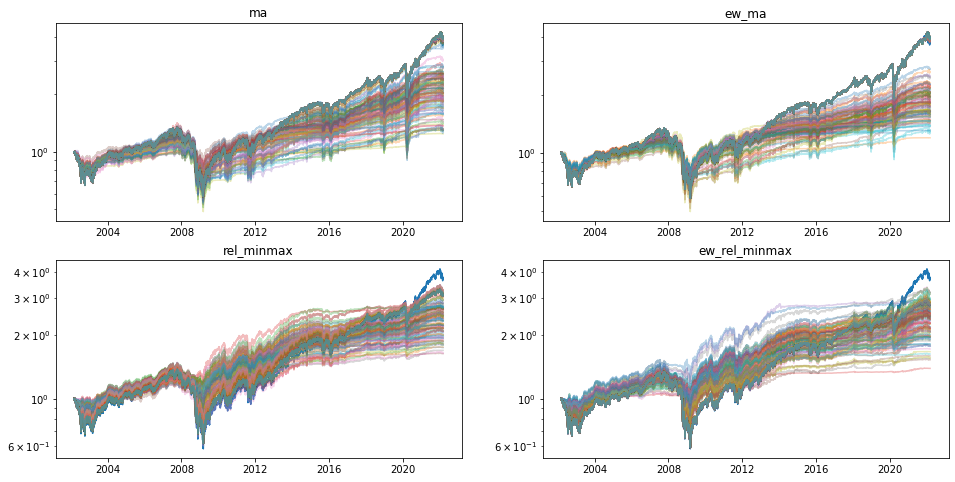

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 6.899977996229624
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 100


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 6.899977996229624
Refitting current best...
Current best ew_ma returns: 9.073671928852336
Fraction Invested: 0.9982041216772393
Beginning random search...
Round: 100
Beginning adjusted search...
Round: 100


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 6.899977996229624
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 100
Beginning adjusted se

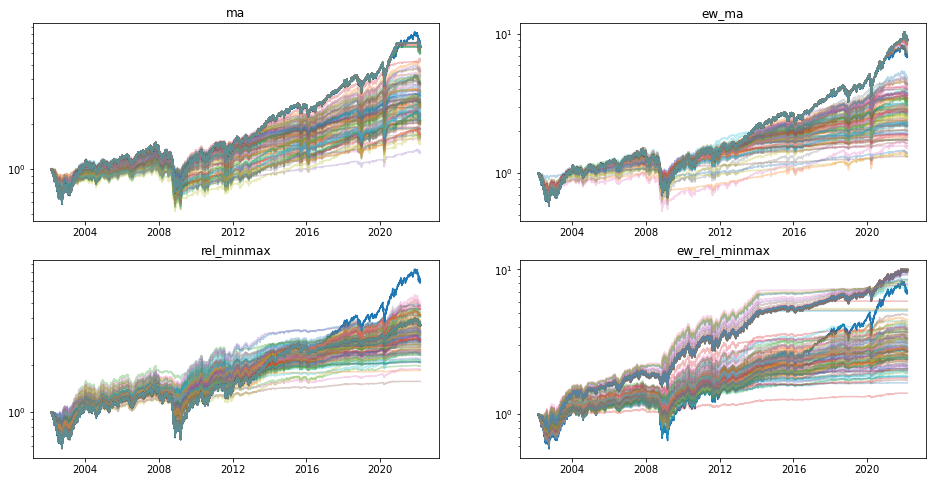

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.5246545405076355
Refitting current best...
Current best ma returns: 3.1313986207120963
Fraction Invested: 0.9999999999999127
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 3.1347999438462937
Invested: 0.9999999999999127
New best: 3.1357497244492207
Invested: 0.9999999999999127
New best: 3.1358966213101356
Invested: 0.9999999999999127
Round: 100


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.5246545405076355
Refitting current best...
Current best ew_ma returns: 2.9498233446227493
Fraction Invested: 8.35442929321995e-05
Beginning random search...
Round: 100
Beginning adjusted search...


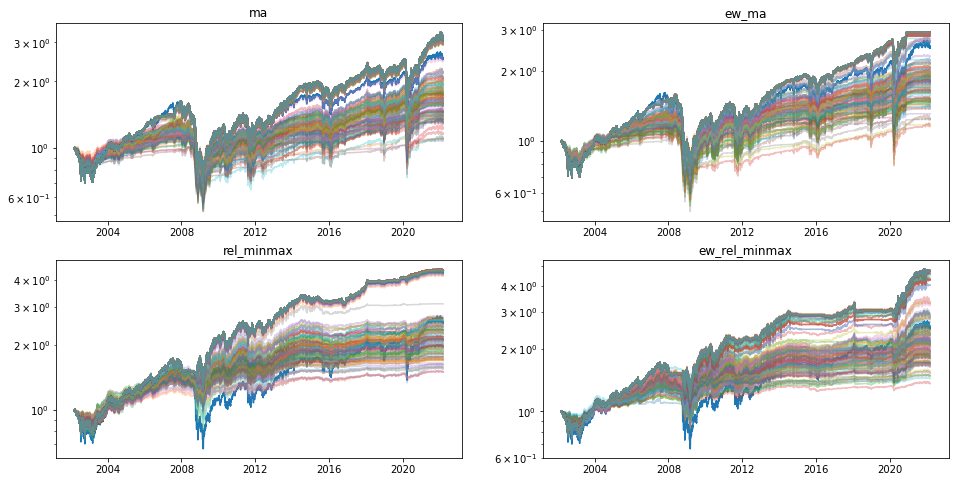

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.9860025113793522
Refitting current best...
Current best ma returns: 4.304989811195696
Fraction Invested: 0.9942055815692069
Beginning random search...
Round: 100
Beginning adjusted search...
New best: 4.305118421398574
Invested: 0.9942055815692069
New best: 4.305118422946551
Invested: 0.9942055815692069
New best: 4.3051190752130015
Invested: 0.9942055815692069
New best: 4.305119076095622
Invested: 0.9942055815692069
Round: 100


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.9860025113793522
Refitting current best...
Current best ew_ma returns: 4.459307990947258
Fraction Invested: 0.9957660812902337
Beginning rando

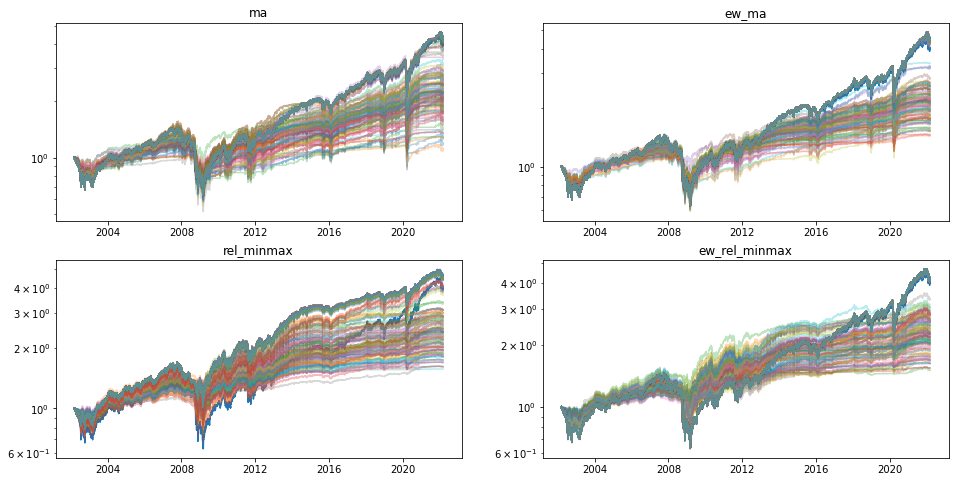

Saving ^W5000 params...


In [30]:
N_RAND = 100
N_ADJ = 100

for stock in batch:
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(stock_data, 
                      N_CUTS, 
                      best_param_set=best_params, 
                      best_returns=best_returns, 
                      sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [35]:
def get_summary(stocks):
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.3f} - {upper:.3f}): {pct:.3f}')
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue

In [36]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
get_summary(batch)


^GSPC:
  Best Return: 3.972572048818941 (ma)
  0.96074543 in
time param: 1079
qs:
(0.000 - 0.464): 1.000
(0.464 - 0.494): 1.000
(0.494 - 0.519): 1.000
(0.519 - 0.556): 1.000
(0.556 - 0.571): 1.000
(0.571 - 0.590): 0.961
(0.590 - 0.613): 0.961
(0.613 - 0.983): 0.961
(0.983 - 0.986): 0.007
(0.986 - 1.000): 0.000

^IXIC:
  Best Return: 9.974972902291908 (ew_rel_minmax)
  0.00000562 in
time param: 1242
qs:
(0.000 - 0.382): 1.000
(0.382 - 0.389): 1.000
(0.389 - 0.447): 0.893
(0.447 - 0.458): 0.893
(0.458 - 0.459): 0.892
(0.459 - 0.466): 0.342
(0.466 - 0.472): 0.342
(0.472 - 0.507): 0.342
(0.507 - 0.985): 0.341
(0.985 - 1.000): 0.000

^NYA:
  Best Return: 4.740666662091119 (ew_rel_minmax)
  0.00007394 in
time param: 436
qs:
(0.000 - 0.496): 1.000
(0.496 - 0.633): 1.000
(0.633 - 0.677): 1.000
(0.677 - 0.677): 1.000
(0.677 - 0.678): 0.460
(0.678 - 0.862): 0.239
(0.862 - 0.863): 0.200
(0.863 - 0.874): 0.200
(0.874 - 0.878): 0.200
(0.878 - 1.000): 0.000

^W5000:
  Best Return: 4.596222122002782

In [37]:
gspc_w = 3.972572048818941 / 3.739715233257489
ixic_w = 9.974972902291908 / 7.075481599471868
nya_w = 4.740666662091119 / 2.5386054003541214
w5k_w = 4.596222122002782 / 4.0255835028846905

w = np.array([gspc_w, ixic_w, nya_w, w5k_w])
print(w)

w_norm = w / w.sum()
print(w_norm)

[1.06226592 1.4097942  1.86742952 1.14175302]
[0.1938002  0.25720339 0.34069455 0.20830186]


In [34]:
!say qp is dunzo